In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


## One to Many RNN

### Download the data

In [7]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip


['Archive:  fra-eng.zip',
 'replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n',
 'replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n']

### Configuration

In [5]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"

### Prepare the data

In [9]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


### Build the model

In [10]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


### Train the model

In [11]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 14s 49ms/step - loss: 1.1615 - accuracy: 0.7351 - val_loss: 1.0355 - val_accuracy: 0.7152
Epoch 2/100
125/125 [==============================] - 5s 38ms/step - loss: 0.8525 - accuracy: 0.7706 - val_loss: 0.8602 - val_accuracy: 0.7598
Epoch 3/100
125/125 [==============================] - 4s 35ms/step - loss: 0.6761 - accuracy: 0.8123 - val_loss: 0.7109 - val_accuracy: 0.7984
Epoch 4/100
125/125 [==============================] - 4s 35ms/step - loss: 0.5834 - accuracy: 0.8315 - val_loss: 0.6481 - val_accuracy: 0.8124
Epoch 5/100
125/125 [==============================] - 4s 35ms/step - loss: 0.5304 - accuracy: 0.8458 - val_loss: 0.5903 - val_accuracy: 0.8273
Epoch 6/100
125/125 [==============================] - 4s 35ms/step - loss: 0.4931 - accuracy: 0.8552 - val_loss: 0.5585 - val_accuracy: 0.8374
Epoch 7/100
125/125 [==============================] - 4s 35ms/step - loss: 0.4635 - accuracy: 0.8633 - val_loss: 0.5344 - val_accuracy

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token.
3. Repeat with the current target token and current states

In [12]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


In [13]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Run.
Decoded sentence: Cours !



# Many to one RNN

### Word sentiment classification

In [14]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

In [15]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [16]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [17]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [18]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [19]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [20]:
X

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]

In [21]:
X_len

[4, 3, 5, 7]

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

In [23]:
X

array([[ 6,  7,  7,  4,  0,  0,  0,  0,  0,  0],
       [ 3,  2,  4,  0,  0,  0,  0,  0,  0,  0],
       [10,  7,  8,  9,  5,  0,  0,  0,  0,  0],
       [ 9,  7,  1,  6,  7,  7,  4,  0,  0,  0]], dtype=int32)

In [24]:
y

[1, 0, 0, 1]

In [25]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [26]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                220       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [28]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [29]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.159576
epoch:  10, tr_loss: 0.009129
epoch:  15, tr_loss: 0.002561
epoch:  20, tr_loss: 0.001409
epoch:  25, tr_loss: 0.000999
epoch:  30, tr_loss: 0.000802


In [30]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [31]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


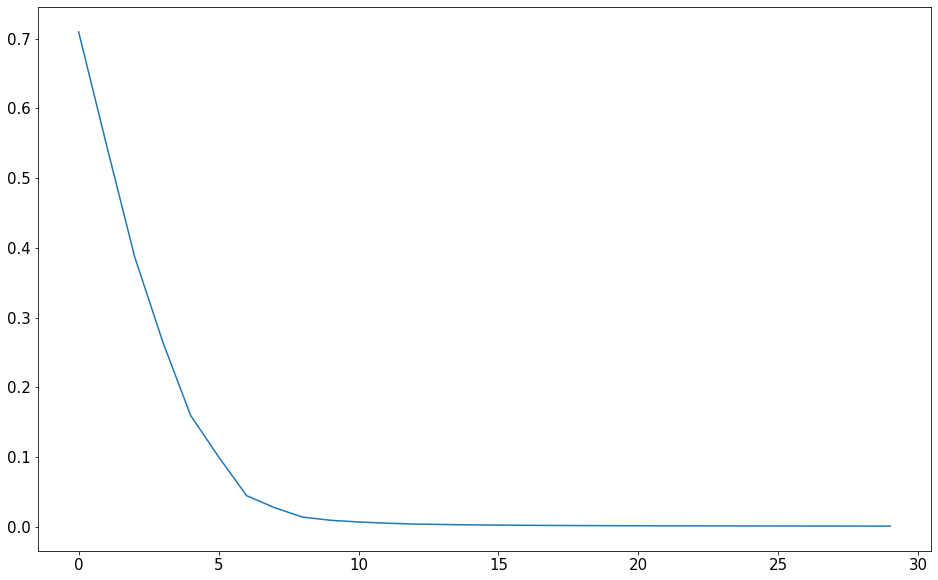

In [32]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

# Many to Many RNN

## Part of Speech Tagging

### Prepraring Dataset

In [33]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [34]:
word_list =['<pad>'] + sorted(set(sum(sentences, []))) 
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)

['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [35]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

print(pos_list)
print(pos2idx)
print(idx2pos)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


In [36]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


In [38]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [39]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)

print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


### Model implementation

In [40]:
num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, TimeDistributed, Dense, SimpleRNN

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, input_length=10,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 15)            225       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 10)            260       
                                                                 
 time_distributed (TimeDistr  (None, 10, 8)            88        
 ibuted)                                                         
                                                                 
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [42]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [43]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_sequence=10)
        grads = tape.gradient(tr_loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, avg_tr_loss))

Epoch:   5, tr_loss: 0.735
Epoch:  10, tr_loss: 0.330
Epoch:  15, tr_loss: 0.182
Epoch:  20, tr_loss: 0.122
Epoch:  25, tr_loss: 0.044
Epoch:  30, tr_loss: 0.018


In [44]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 3., 4., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

In [45]:
from pprint import pprint

y_pred_pos = list(map(lambda row: [idx2pos.get(elm) for elm in row], y_pred.astype(np.int32).tolist()))

pprint(y_pred_pos)

pprint(pos)

[['pronoun',
  'verb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'determiner',
  'noun',
  'preposition',
  'adjective',
  'noun',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'verb',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


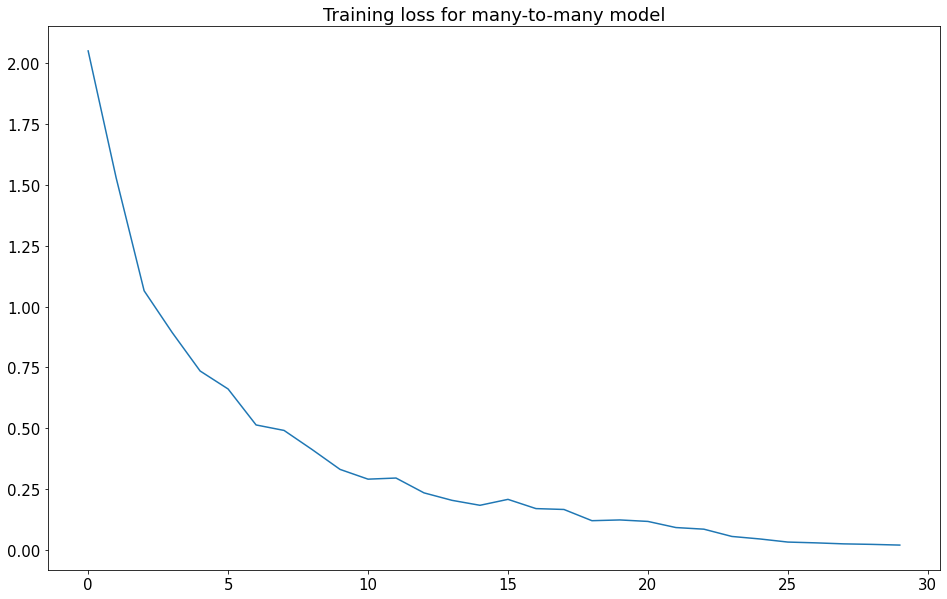

In [46]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many model')
plt.show()